# Rimozione dei campioni senza annotazioni
Di seguito viene scansionato il file .record contenente i campioni per l'addestramento. Scopo dell'analisi è identificare quale immagini sono presenti ma non possiedono oggetti da identificare al suo interno. Una volta trovati, vengono eliminati perchè aggiungono esempi di sfondo sbilanciando così il dataset. 

In [ ]:
import tensorflow as tf
import numpy as np
import IPython.display as display

print(tf.__version__)

2.5.0


## Verifico le feature memorizzate

In [ ]:
in_filename = "annotations/coco_train.record-00000-of-00001"

for raw_record in tf.data.TFRecordDataset(in_filename).take(1):
    
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    for f in example.features.feature:
        print(f)

image/object/bbox/xmin
image/object/area
image/height
image/object/bbox/ymin
image/object/is_crowd
image/object/bbox/xmax
image/encoded
image/object/class/text
image/source_id
image/format
image/key/sha256
image/width
image/object/bbox/ymax
image/filename


In [ ]:
image_feature_description = {
    'image/filename': tf.io.FixedLenFeature([], tf.string),
    'image/height': tf.io.FixedLenFeature([], tf.int64),
    'image/width': tf.io.FixedLenFeature([], tf.int64),
    'image/source_id': tf.io.FixedLenFeature([], tf.string),
    'image/object/bbox/xmin': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),
    'image/object/bbox/xmax': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),
    'image/object/bbox/ymin': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),
    'image/object/bbox/ymax': tf.io.FixedLenSequenceFeature([], tf.float32,allow_missing=True),
    'image/object/class/text': tf.io.FixedLenSequenceFeature([], tf.string,allow_missing=True),
    'image/encoded': tf.io.FixedLenFeature([], tf.string)
}

## Conteggio delle immagini senza annotazioni


In [ ]:
count = 0
filenames = []
images = []
for raw_record in tf.data.TFRecordDataset(in_filename):
    parsed = tf.io.parse_single_example(raw_record, image_feature_description)
    image_class = parsed['image/object/class/text']
    image_filename = parsed['image/filename']
    image_encoded = parsed['image/encoded']
    if len(image_class) == 0:
        count += 1
        filenames.append(image_filename.numpy())
        images.append(image_encoded.numpy())

Sono presenti 1002 immagini senza annotazioni.


b'thermal_8_bit/FLIR_00023.jpeg'


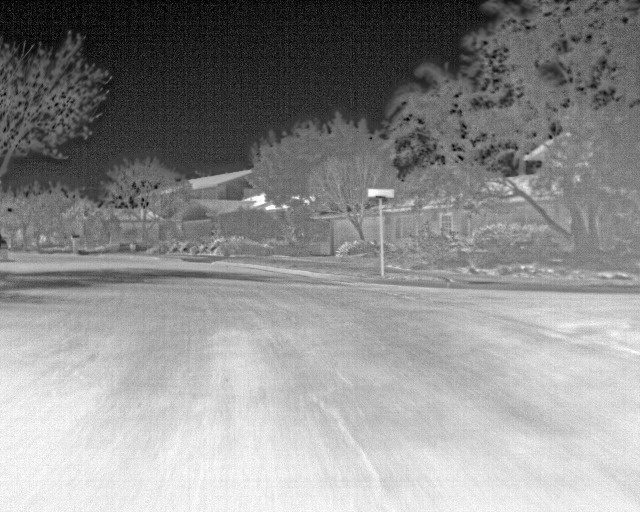


b'thermal_8_bit/FLIR_00029.jpeg'


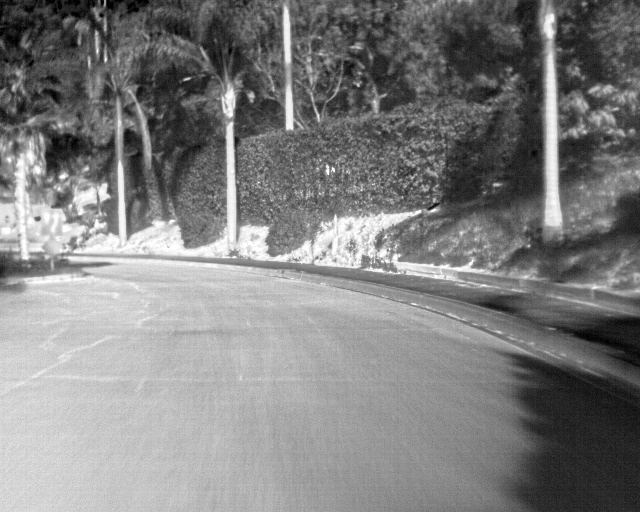


b'thermal_8_bit/FLIR_00034.jpeg'


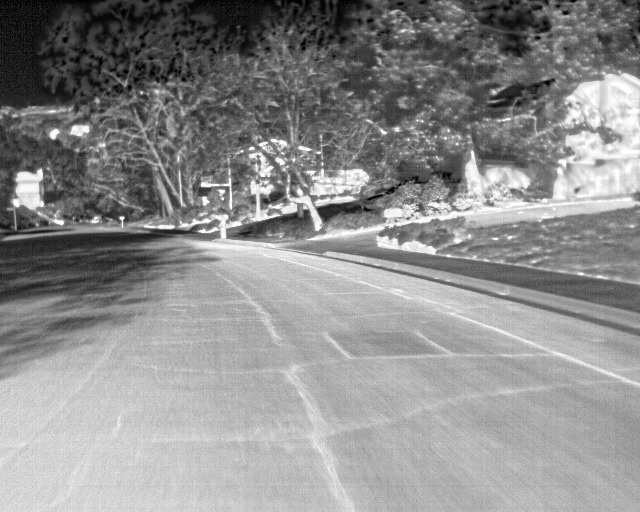


b'thermal_8_bit/FLIR_00037.jpeg'


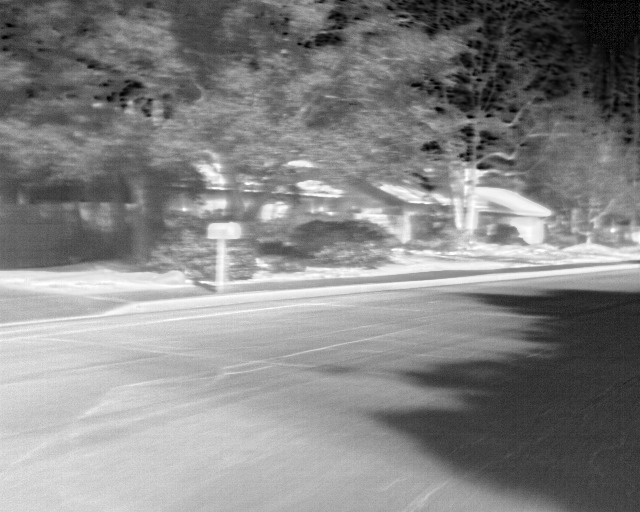


b'thermal_8_bit/FLIR_00048.jpeg'


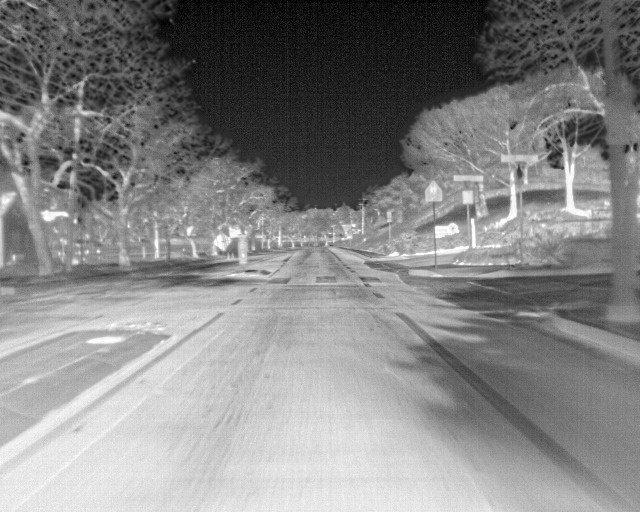

In [ ]:
print("Sono presenti {0} immagini senza annotazioni.\n".format(count))

for i in range(0,5):
  print()
  print(filenames[i])
  display.display(display.Image(data=images[i]))

## Filtraggio
Alcuni record hanno la feature "class" vuota. Significa che alcune immagini sono senza annotazioni. Quindi, creo un nuovo dataset filtrando via solo i record che possiedono tale caratteristica.

In [ ]:
out_filename = "annotations/train.record"

def decode_fn(record_bytes):
    return tf.io.parse_single_example(record_bytes, image_feature_description)

def is_annotated(record_bytes):
    parsed = tf.io.parse_single_example(record_bytes, image_feature_description)
    image_class = parsed['image/object/class/text']
    return len(image_class) > 0

In [ ]:
with tf.io.TFRecordWriter(out_filename) as writer:
    for raw_record in tf.data.TFRecordDataset(in_filename).filter(is_annotated):
        writer.write(raw_record.numpy())

## Verifico l'avvenuto salvataggio

In [ ]:
for raw_record in tf.data.TFRecordDataset(out_filename).take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())

    for f in example.features.feature:
        print(f)

image/object/area
image/object/bbox/xmax
image/object/bbox/ymax
image/height
image/filename
image/key/sha256
image/source_id
image/object/bbox/xmin
image/format
image/width
image/encoded
image/object/is_crowd
image/object/bbox/ymin
image/object/class/text


In [ ]:
for batch in tf.data.TFRecordDataset(out_filename).map(decode_fn).take(50):
  print()
  print("file name: {image/filename}\nid: {image/source_id}\nclass: {image/object/class/text} ".format(**batch))


file name: b'thermal_8_bit/FLIR_00001.jpeg'
id: b'0'
class: [b'car' b'car' b'car' b'car'] 

file name: b'thermal_8_bit/FLIR_00002.jpeg'
id: b'1'
class: [b'car' b'car' b'car' b'car' b'car' b'car'] 

file name: b'thermal_8_bit/FLIR_00003.jpeg'
id: b'2'
class: [b'car' b'car' b'car' b'car' b'car'] 

file name: b'thermal_8_bit/FLIR_00004.jpeg'
id: b'3'
class: [b'car' b'car' b'car' b'car' b'car' b'person' b'car' b'car' b'car' b'car'] 

file name: b'thermal_8_bit/FLIR_00005.jpeg'
id: b'4'
class: [b'car' b'car' b'car' b'car' b'car' b'car' b'car' b'car' b'car' b'car'] 

file name: b'thermal_8_bit/FLIR_00006.jpeg'
id: b'5'
class: [b'car' b'car'] 

file name: b'thermal_8_bit/FLIR_00007.jpeg'
id: b'6'
class: [b'car' b'car'] 

file name: b'thermal_8_bit/FLIR_00008.jpeg'
id: b'7'
class: [b'car' b'car' b'car'] 

file name: b'thermal_8_bit/FLIR_00009.jpeg'
id: b'8'
class: [b'car' b'car' b'car'] 

file name: b'thermal_8_bit/FLIR_00010.jpeg'
id: b'9'
class: [b'person' b'car' b'car' b'car' b'car' b'car'